In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patheffects as PathEffects

In [2]:
from uriel import Uriel
u = Uriel(load=True, umap=True)

/tmp/ipykernel_116/4015161818.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(labels)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


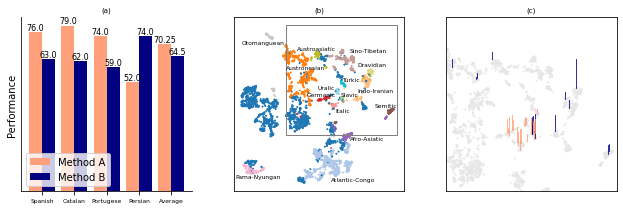

In [83]:
plt.rcParams["figure.figsize"] = (9,3)
from papers import papers
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.1)

labels = ['Spanish', 'Catalan', 'Portugese', 'Persian', 'Average']
a_means = [76, 79, 74, 52]
a_means.append(np.mean(a_means))
b_means = [63, 62, 59, 74]
b_means.append(np.mean(b_means))

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig.tight_layout()
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
rects1 = axes[0].bar(x - width/2, a_means, width, label='Method A', color='lightsalmon')
rects2 = axes[0].bar(x + width/2, b_means, width, label='Method B', color='navy')

# Add some text for labels, title and custom x-axis tick labels, etc.
axes[0].set_ylabel('Performance')

axes[0].tick_params(axis='x', which='major', labelsize=9)
axes[0].set_xticklabels(labels)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        axes[0].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),
                    textcoords="offset points",
                    ha='center', va='bottom', color='black', fontsize=8)


autolabel(rects1)
autolabel(rects2)

axes[0].legend(loc=3)

for ax, c in zip(axes, 'abc'):
    ax.set_xticks([])
    ax.set_yticks([])
    eh = ax.set_title(f'({c})', fontsize=7)
axes[0].set_xticks(x)
axes[0].tick_params(axis='x', which='major', labelsize=6)

axes[1].scatter(u.umap_vectors.embedding_[:,0], u.umap_vectors.embedding_[:,1],
            c=u.language_metadata(u.uriel_languages)['label'],
            s=1,
            cmap='tab20')
axes[1].add_patch(Rectangle((4, 2), 20, 20, fill=False, edgecolor='gray'),)

rahimi_lang, rahimi_scores = papers['rahimi_ner']
heinzer_lang, heinzer_scores = papers['heinzerling_pos']

cut = u.umap_vectors.embedding_
cut = cut[cut[:, 0] > 4]
cut = cut[cut[:, 0] < 24]
cut = cut[cut[:, 1] > 2]
cut = cut[cut[:, 1] < 22]

score1 = dict(zip(rahimi_lang, rahimi_scores[:, 2]))
score2 = dict(zip(rahimi_lang, rahimi_scores[:, 11]))
metadata = u.language_metadata(u.uriel_languages)
metadata = metadata[metadata['code'].isin(rahimi_lang)]
diff = {l: score2[l] / score1[l] - 1 for l in metadata['code']}
metadata = metadata.assign(
    x=u.umap_vectors.embedding_[metadata.index][:,0],
    y=u.umap_vectors.embedding_[metadata.index][:,1],
    width=0.05,
    height=[diff[l] for l in metadata['code']],
    color=['#66ee66' if diff[l] > 0 else '#ee6666' for l in metadata['code']],
)
metadata['height'] /= max(metadata['height'])
metadata['height'] *= 2

axes[2].scatter(cut[:, 0], cut[:, 1], s=1, c=(0.9, 0.9, 0.9))
for x, y, h in zip(metadata['x'], metadata['y'], metadata['height'],):
    if h > 0:
        axes[2].plot([x, x], [y, y+h], c='lightsalmon', linewidth=0.8)
    else:
        axes[2].plot([x, x], [y, y-h], c='navy', linewidth=0.8) 

axes[2].set_xlim((4, 24))
axes[2].set_ylim((2, 22))

axes[1].text(12.2, -6.5, 'Atlantic-Congo', fontsize=6)
axes[1].text(15.6, 1, 'Afro-Asiatic', fontsize=6)
axes[1].text(20, 7, 'Semitic', fontsize=6)
axes[1].text(-5, -6, 'Pama-Nyungan', fontsize=6)
axes[1].text(-4, 18.5, 'Otomanguean', fontsize=6)
axes[1].text(13, 6.2, 'Italic', fontsize=6)
axes[1].text(14, 9, 'Slavic', fontsize=6)
axes[1].text(7.8, 9.1, 'Germanic', fontsize=6)
axes[1].text(9.8, 10.3, 'Uralic', fontsize=6)
axes[1].text(17, 9.7, 'Indo-Iranian', fontsize=6)
axes[1].text(17, 14.5, 'Dravidian', fontsize=6)
axes[1].text(14.2, 11.7, 'Turkic', fontsize=6)
axes[1].text(15.5, 17, 'Sino-Tibetan', fontsize=6)
axes[1].text(6, 17.5, 'Austroasiatic', fontsize=6)
axes[1].text(4, 14, 'Austronesian', fontsize=6)

plt.savefig('fig2.pdf', bbox_inches='tight')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


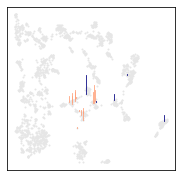

In [84]:
plt.rcParams["figure.figsize"] = (3,3)
from papers import papers
from matplotlib.patches import Rectangle

rahimi_lang, rahimi_scores = papers['heinzerling_pos']

cut = u.umap_vectors.embedding_
cut = cut[cut[:, 0] > 4]
cut = cut[cut[:, 0] < 24]
cut = cut[cut[:, 1] > 2]
cut = cut[cut[:, 1] < 22]

score1 = dict(zip(rahimi_lang, rahimi_scores[:, 0]))
score2 = dict(zip(rahimi_lang, rahimi_scores[:, 10]))
metadata = u.language_metadata(u.uriel_languages)
metadata = metadata[metadata['code'].isin(rahimi_lang)]
diff = {l: score2[l] / score1[l] - 1 for l in metadata['code']}
metadata = metadata.assign(
    x=u.umap_vectors.embedding_[metadata.index][:,0],
    y=u.umap_vectors.embedding_[metadata.index][:,1],
    width=0.05,
    height=[diff[l] for l in metadata['code']],
    color=['#66ee66' if diff[l] > 0 else '#ee6666' for l in metadata['code']],
)
metadata['height'] /= max(metadata['height'])
metadata['height'] *= 2

plt.scatter(cut[:, 0], cut[:, 1], s=1, c=(0.9, 0.9, 0.9))
for x, y, h in zip(metadata['x'], metadata['y'], metadata['height'],):
    if h > 0:
        plt.plot([x, x], [y, y+h], c='lightsalmon', linewidth=0.8)
    else:
        plt.plot([x, x], [y, y-h], c='navy', linewidth=0.8) 

plt.xlim = (4, 24)
plt.ylim = (2, 22)
plt.tick_params(left = False, labelleft = False, bottom=False, labelbottom = False)
plt.savefig('fig4.pdf', bbox_inches='tight')

In [5]:
from visualizations import show_uriel

show_uriel(u)

Loading BokehJS ...

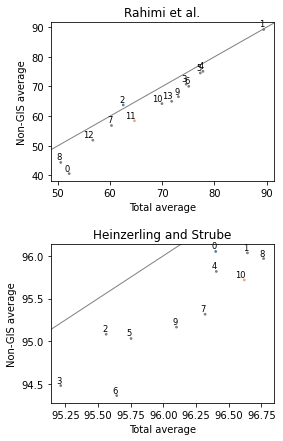

In [6]:
from matplotlib.collections import LineCollection
plt.rcParams["figure.figsize"] = (4, 7)

languages, scores = papers['rahimi_ner']
family = {'Germanic', 'Italic', 'Slavic'}

fig, axes = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.4)
for ax, languages, scores, red, green, title in zip(axes, *zip(papers['rahimi_ner'], papers['heinzerling_pos']), [2, 0], [11, 10], ['Rahimi et al.', 'Heinzerling and Strube']):
    xs = np.mean(scores, axis=0)        
    ys = np.mean(scores[
        [i
         for i, l
         in enumerate(languages)
         if not u.is_in_family(l, family)
        ]
    ], axis=0)
    col = LineCollection(segments=[[(0,0), (100,100)]], linewidths=1, colors='gray')
    ax.add_collection(col, autolim=False)
    colors = ['gray' for _ in range(len(xs))]
    colors[red] = 'steelblue'
    colors[green] = 'lightsalmon'
    ax.scatter(xs, ys, c=colors, s=3)
    ax.set_xlabel('Total average')
    ax.set_ylabel('Non-GIS average')
    ax.set_title(title)
    for i, xy in enumerate(zip(xs, ys)):     
        ax.annotate(
            text=i,
            xy=xy,
            xytext=(1, 1),
            textcoords='offset points',
            ha='right',
            va='bottom',
            fontsize='small')
plt.savefig('fig3.pdf', bbox_inches='tight')

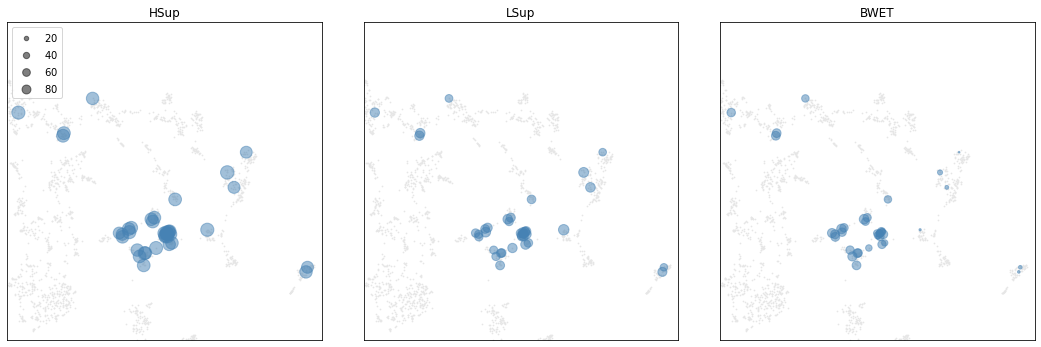

In [93]:

from papers import papers
from matplotlib.patches import Rectangle

rahimi_lang, rahimi_scores = papers['rahimi_ner']

scores = [
 rahimi_scores[:,i]
 for i in [1,2,8]
]

plt.rcParams["figure.figsize"] = (5 * len(scores), 5)
fig, axes = plt.subplots(1, len(scores))
plt.subplots_adjust(wspace=0.1)

fig.tight_layout()

titles = ['HSup', 'LSup', 'BWET']

for i, ax in enumerate(axes):
        
    cut = u.umap_vectors.embedding_
    cut = cut[cut[:, 0] > 4]
    cut = cut[cut[:, 0] < 24]
    cut = cut[cut[:, 1] > 2]
    cut = cut[cut[:, 1] < 22]

    score = dict(zip(rahimi_lang, scores[i]))
    metadata = u.language_metadata(u.uriel_languages)
    metadata = metadata[metadata['code'].isin(rahimi_lang)]
    metadata = metadata.assign(
        x=u.umap_vectors.embedding_[metadata.index][:,0],
        y=u.umap_vectors.embedding_[metadata.index][:,1],
        size=[score[l]**2/50 for l in metadata['code']],
    )

    ax.scatter(cut[:, 0], cut[:, 1], s=0.5, color=(0.9, 0.9, 0.9))
    sc = ax.scatter(metadata['x'], metadata['y'], c='steelblue', s=metadata['size'], alpha=0.5) 

    ax.set_xlim((4, 24))
    ax.set_ylim((2, 22))
    ax.tick_params(left = False, labelleft = False, bottom=False, labelbottom = False)
    ax.set_title(titles[i])

axes[0].legend(*sc.legend_elements("sizes", num=5), loc=2)

plt.savefig('fig5.pdf', bbox_inches='tight')

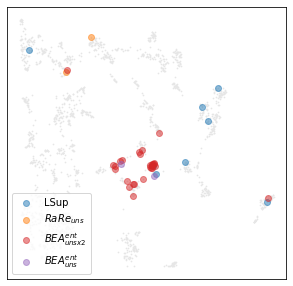

In [138]:

from papers import papers
from matplotlib.patches import Rectangle

rahimi_lang, rahimi_scores = papers['rahimi_ner']
scores = dict(zip(rahimi_lang, rahimi_scores[:,[2,7,8,9,10,11,12]]))
for l, score in scores.items():
    scores[l] = np.where(score == max(score))[0][0]
plt.rcParams["figure.figsize"] = (5, 5)
        
cut = u.umap_vectors.embedding_
cut = cut[cut[:, 0] > 4]
cut = cut[cut[:, 0] < 24]
cut = cut[cut[:, 1] > 2]
cut = cut[cut[:, 1] < 22]

metadata = u.language_metadata(u.uriel_languages)
metadata = metadata[metadata['code'].isin(rahimi_lang)]
metadata = metadata.assign(
    x=u.umap_vectors.embedding_[metadata.index][:,0],
    y=u.umap_vectors.embedding_[metadata.index][:,1],
    win=[scores[l] for l in metadata['code']],
)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', '-', '-', 'tab:pink', '-', '-', '-', 'tab:brown']


plt.scatter(cut[:, 0], cut[:, 1], s=0.5, color=(0.9, 0.9, 0.9))
names = {
    0: 'LSup',
    1: '$RaRe_{uns}$',
    3: '$BEA^{ent}_{uns x2}$',
    4: '$BEA^{ent}_{uns}$',
}
for c in set(scores.values()):
    mtd = metadata[metadata['win'] == c]
    plt.scatter(mtd['x'], mtd['y'], c=colors[c], alpha=0.5, label=names[c]) 

# plt.xlim = (4, 24)
# plt.ylim((2, 22))
plt.tick_params(left = False, labelleft = False, bottom=False, labelbottom = False)
# plt.set_title(titles[i])

plt.legend(loc=3)

plt.savefig('fig6.pdf', bbox_inches='tight')